# Titanic - Machine Learning from Disaster
## Predicting survivors of the Titanic shipwreck

<p align='center'>
    <img src='img/titanic.jpg'>
</p>

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we want to build a model that predicts which passengers survived the Titanic shipwreck, using data (ie name, age, gender, socio-economic class, etc).

To solve the problem, we will follow these step:

- **0.0.** Data Collection.
- **1.0.** Data description.
- **2.0.** Feature Engineering
- **3.0.** Filtering the features
- **4.0.** Exploratory Data Analysis
- **5.0.** Data preparation
- **6.0.** Feature selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter fine tuning
- **9.0.** Translation and interpretation of the error
- **10.0.** Deploy model to production

# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.ensemble import RandomForestClassifier

from IPython.display       import Image

## 0.1. Helper functions

in this step, we'll document all the functions that will be used to solve the problem.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

### Overview

Here we will import the data we will need to predict the survivors of the wreck.

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set will be used to build our machine learning models. Our model will be based on “characteristics” such as gender and class of passengers. We will also use feature engineering to create new features.

The test set will be used to see how well our model performs on unseen data. For each passenger in the test set, we'll use the model we've trained to predict whether or not they survived the sinking of the Titanic.

We also have gender_submission.csv, a set of predictions that assume all and only women survive, and we will use that as the baseline for our solution.

### Data Dictionary

| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


### Data assumptions

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

We'll load **"train.csv"** and **"test.csv"** and unite them to build a dataframe that will call **"df_raw"**. 

In [59]:
train = pd.read_csv( 'datasets/titanic/train.csv' )
test = pd.read_csv( 'datasets/titanic/test.csv' )

df_raw = pd.concat( [train, test], axis=0 ).reset_index()
df_raw.drop( 'index', axis=1, inplace=True )

df_raw.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1123,1124,NaN,3,"Wiklund, Mr. Karl Johan",male,21.0,1,0,3101266,6.4958,NaN,S


# 1.0. Data Description

in this step we will perform the following tasks:

- Rename Columns
- Data Dimensions
- Data Types
- Check missing values
- Fillout missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [64]:
df1 = df_raw.copy()

In [26]:
df1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 1.1. Rename Columns

In this first step we will rename the columns to be more understandable. We will use the snake case pattern.

In [65]:
df1.columns = ['Passenger_id', 'Survived', 'Ticket_class', 'Name', 'Sex', 'Age', 'Acc_siblings_or_spouses',
             'Acc_parents_or_children', 'Ticket', 'Fare', 'Cabin', 'Embarked']

## 1.2. Data Dimensions

Let's see the size of the dataset dimensions.

In [28]:
# Train dataset
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1309
Number of columns: 12


## 1.3. Data Types

In this step we want to see what the data types are. This is important for us to treat the data correctly, and change them if necessary.

In [54]:
df1.dtypes

Passenger_id                 int64
Survived                   float64
Ticket_class                 int64
Name                        object
Sex                         object
Age                        float64
Acc_siblings_or_spouses      int64
Acc_parents_or_children      int64
Ticket                      object
Fare                       float64
Cabin                       object
Embarked                    object
dtype: object

## 1.4. Check NA

In this step, we want to see if there are any missing values in the dataset. If so, we must solve this problem because our machine learning algorithms are not able to handle null values.

In [30]:
# Train dataset
df1.isna().sum().sort_values( ascending=False )

Cabin                      1014
Survived                    418
Age                         263
Embarked                      2
Fare                          1
Ticket                        0
Acc_parents_or_children       0
Acc_siblings_or_spouses       0
Sex                           0
Name                          0
Ticket_class                  0
Passenger_id                  0
dtype: int64

## 1.5. Fillout NA

As we saw in the previous step, there are four variables in the dataset that have missing values: Cabin, Survived, Age, Fare and Embarked.
We'll explain how to solve the problem in each variable.

- Survived
    - the missing values in this column are from the data that will be used to test the model, so they do not need to be filled.

- Cabin
    - This variable will probably not be useful for the predictive model and has a large number of missing values, so we will delete it.

- Age
    - For this variable we will use the mean or median.
    
- Fare
    - There is only one missing value in the test dataset, so in this case we will just fill with the mean.
    
- Embarked
    - There are only two missing values in the training dataset, so in this case let's just fill in the mode.

In [66]:
# Cabin 
df1.drop( 'Cabin', axis=1, inplace=True )

# Fare
df1['Fare'].fillna( float( format( np.mean( df1['Fare'] ), ".4f" )  ), inplace=True )

# Embarked
df1['Embarked'].fillna( df1['Embarked'].mode()[0], inplace=True )

Now, to fill in the missing values from the age column, we will first look at how the passengers' ages are distributed. As we can see, most passengers are in the 20 to 30 age range.

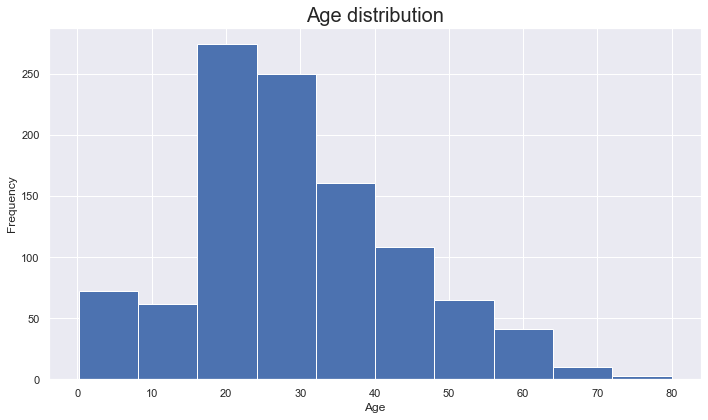

In [73]:
fig, ax = subplots( figsize=(10, 6) )

ax.hist( 'Age', data=df1 )
ax.set_title( 'Age distribution', fontsize=20 )
ax.set_xlabel( 'Age' )
ax.set_ylabel( 'Frequency' )

plt.tight_layout()

We will use a measure of centrality to fill in the missing values. However, we will first plot a boxplot to see if there are any outliers in the dataset. As we can see, both the training and testing datasets have outliers, so we will use the median as it is less affected by outliers.

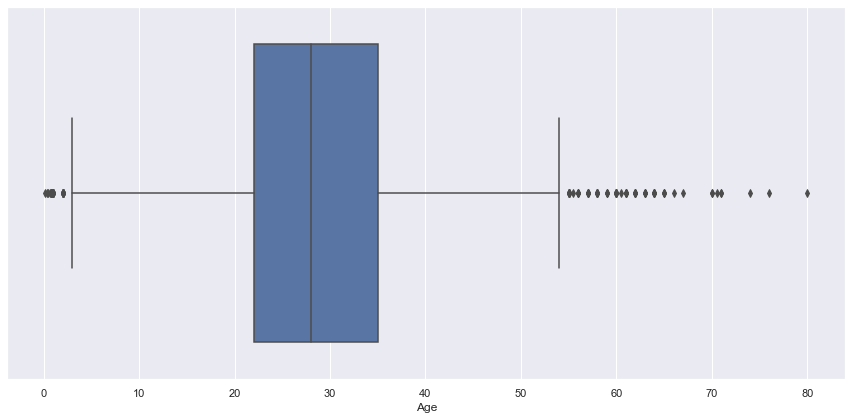

In [24]:
fig, ax = subplots( figsize=(12,6) )

sns.boxplot( x=df1['Age'], ax=ax )

plt.tight_layout()

In [75]:
print('Median:', int( df1['Age'].median() ) )

Median: 28


In [68]:
df1['Age'].fillna( df1['Age'].median(), inplace=True )

## 1.6. Descriptive Statistical

For this step we will separate the numeric and categorical variables.

In [69]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1[['Sex', 'Embarked']]

### 1.6.1. Numerical Attributes

For the numerical variables we use two types of analysis.

- Central tendency
    - average
    - median
    
- Dispersion
    - count
    - std - standard deviation
    - min
    - max
    - first quartile
    - third quartile

In [70]:
num_attributes.describe()

,Passenger_id,Survived,Ticket_class,Age,Acc_siblings_or_spouses,Acc_parents_or_children,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.503186,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,12.905241,1.041658,0.865560,51.738879
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### 1.6.2. Categorical Attributes

For categorical variables we will use the countplot, which show the counts of observations in each categorical bin using bars.

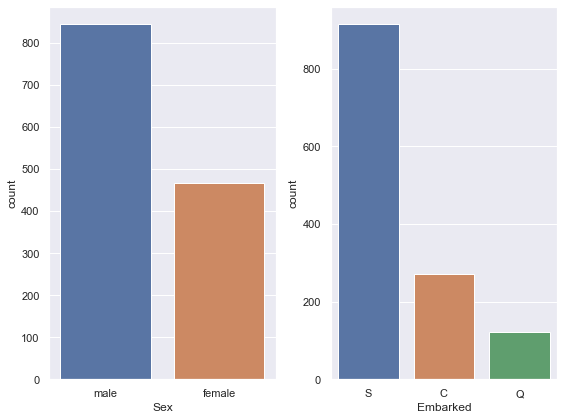

In [36]:
fig, ax = subplots( nrows=1, ncols=2, figsize=(8, 6) )
sns.countplot( x = cat_attributes['Sex'], ax=ax[0] )

sns.countplot( x = cat_attributes['Embarked'], ax=ax[1] )

plt.tight_layout()

# 2.0. Feature Engineering

In [71]:
df2 = df1.copy()

In this step, we created a mind map hypothesis, in order to visualize all the variables we have and create relevant hypotheses for this context. Next, we'll create features that will be important for exploratory data analysis.

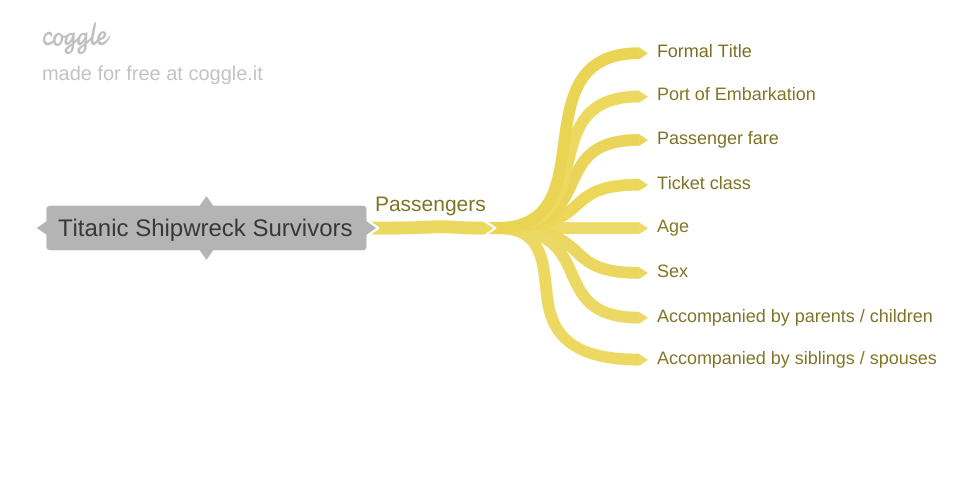

In [12]:
Image('img/Titanic_Shipwreck_Survivors.png')

## 2.1. Creation of Hypothesis

**1.** Passengers accompanied by parents or children survived less

**2.** Passengers accompanied by siblings or spouses survived more

**3.** Passengers with the title of ... survived more

**4.** Passengers who boarded the port of southampton survived more

**5.** Children or elderly passangers survived more

**6.** Female passengers survived more

**7.** 1st class passengers survived more

**8.** Passengers who paid more expensive fares survived more

## 2.2. Feature Engineering

To validate our hypotheses we need to create just one more feature: formal title.

In [72]:
df2['Formal_title'] = 'na'
df2['Formal_title'] = df2['Name'].apply( lambda x: 'Miss' if 'Miss' in x else
                                                 'Mrs' if 'Mrs' in x else 
                                                 'Master' if 'Master' in x else 
                                                 'Col' if 'Col' in x else 
                                                 'Major' if 'Major' in x else 'Mr' )

# 3.0. Data Filtering

In [73]:
df3 = df2.copy()

In [40]:
df3.head()

,Passenger_id,Survived,Ticket_class,Name,Sex,Age,Acc_siblings_or_spouses,Acc_parents_or_children,Ticket,Fare,Cabin,Embarked,Formal_title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In this step we will ensure that we only use the relevant information to resolve the issue. For this we will separate this step into two:

**1.** Filtering Rows

**2.** Filtering Columns

## 3.1. Filtering Rows

Previously, we merged the training and testing datasets to perform data cleaning and preparation. However, as the test data does not have the variable "survived", we will remove it from this dataframe. Test data will be used in later steps.

In [74]:
# filtering the rows
df3 = df3[df3['Survived'].notna()]

## 3.2. Filtering Columns

Now, we are going to remove the columns that will not be needed for the next steps and for training the model.

**1.** Passenger_id - This variable will not be relevant in this case.

**2.** Name - This variable has already been used to create the formal title feature, however it will no longer be needed.

**3.** Ticket - This variable will not be relevant in this case.

In [75]:
df3.drop( columns=['Passenger_id', 'Name', 'Ticket'], axis=1, inplace=True )

# 4.0. Exploratory Data Analysis

In this step, we will perform an exploratory data analysis to better understand the data and gain insights. We'll do 3 types of analysis:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

In [76]:
df4 = df3.copy()

## 4.1. Univariate Analysis

Univariate analysis is the most basic form of statistical data analysis technique. When the data contains only one variable and doesn’t deal with a causes or effect relationships then a Univariate analysis technique is used.

### 4.1.1. Response Variable

We build a countplot to see the number of observations for each class. In this case, how many passengers survived and how many died. As we can see, a little more than three hundred passengers survived and more than five hundred died.

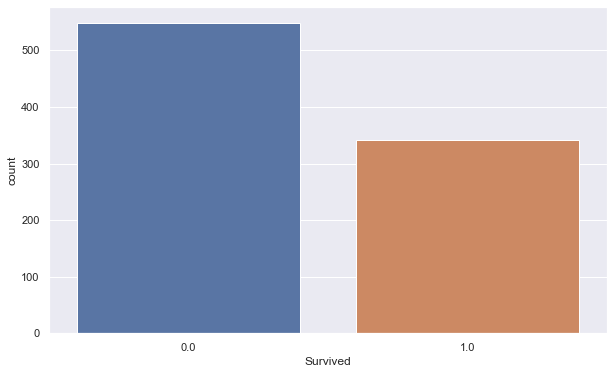

In [99]:
fig, ax = subplots( figsize = (10, 6) )

sns.countplot( x = df4['Survived'] );

plt.show()

### 4.1.2. Numerical Variable

For the numeric variables, we draw a histogram to visualize the distribution of each feature.

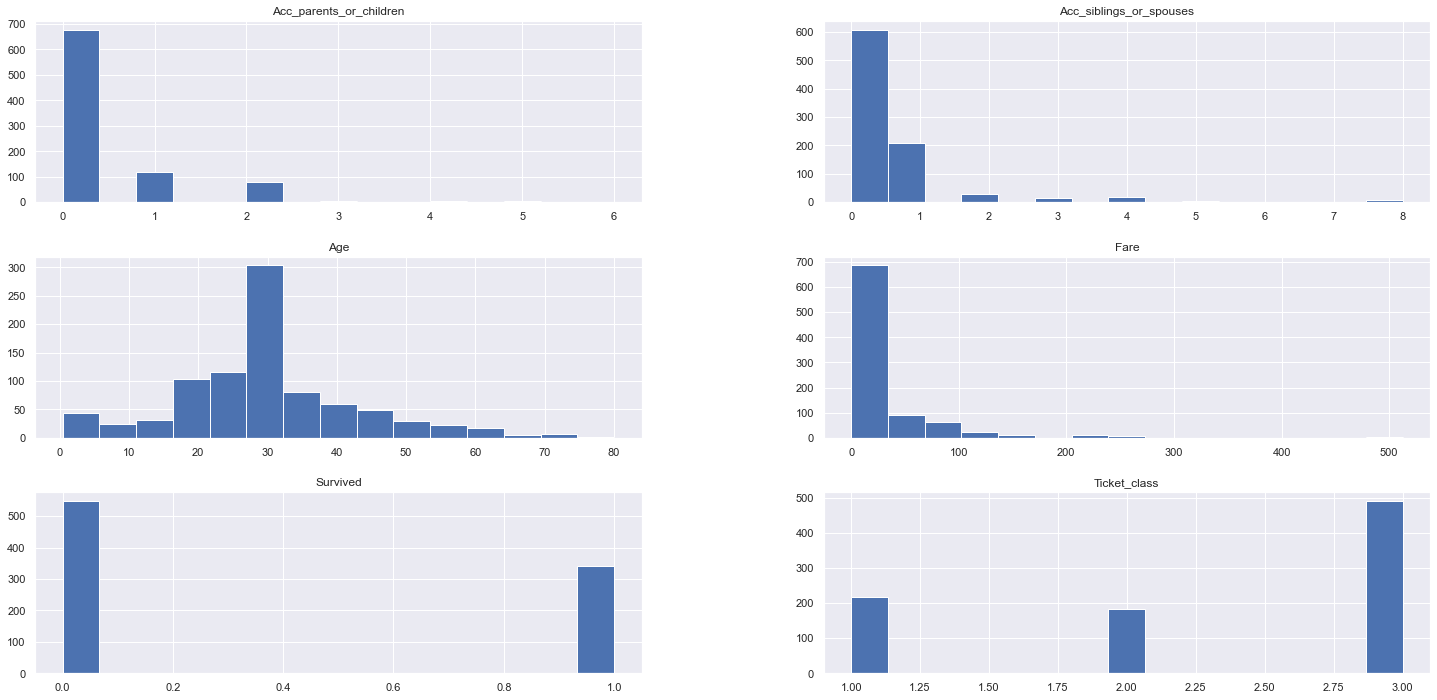

In [77]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )
num_attributes.hist( bins=15 );

From the graphs above, we can get some conclusions:

- **Age**: Most passengers were in their 30s.
- **Ticket_class**: Most passengers were in 3rd class.

### 4.1.3. Categorical Variable

In [80]:
df4.select_dtypes( include=['object'] ).columns

Index(['Sex', 'Embarked', 'Formal_title'], dtype='object')

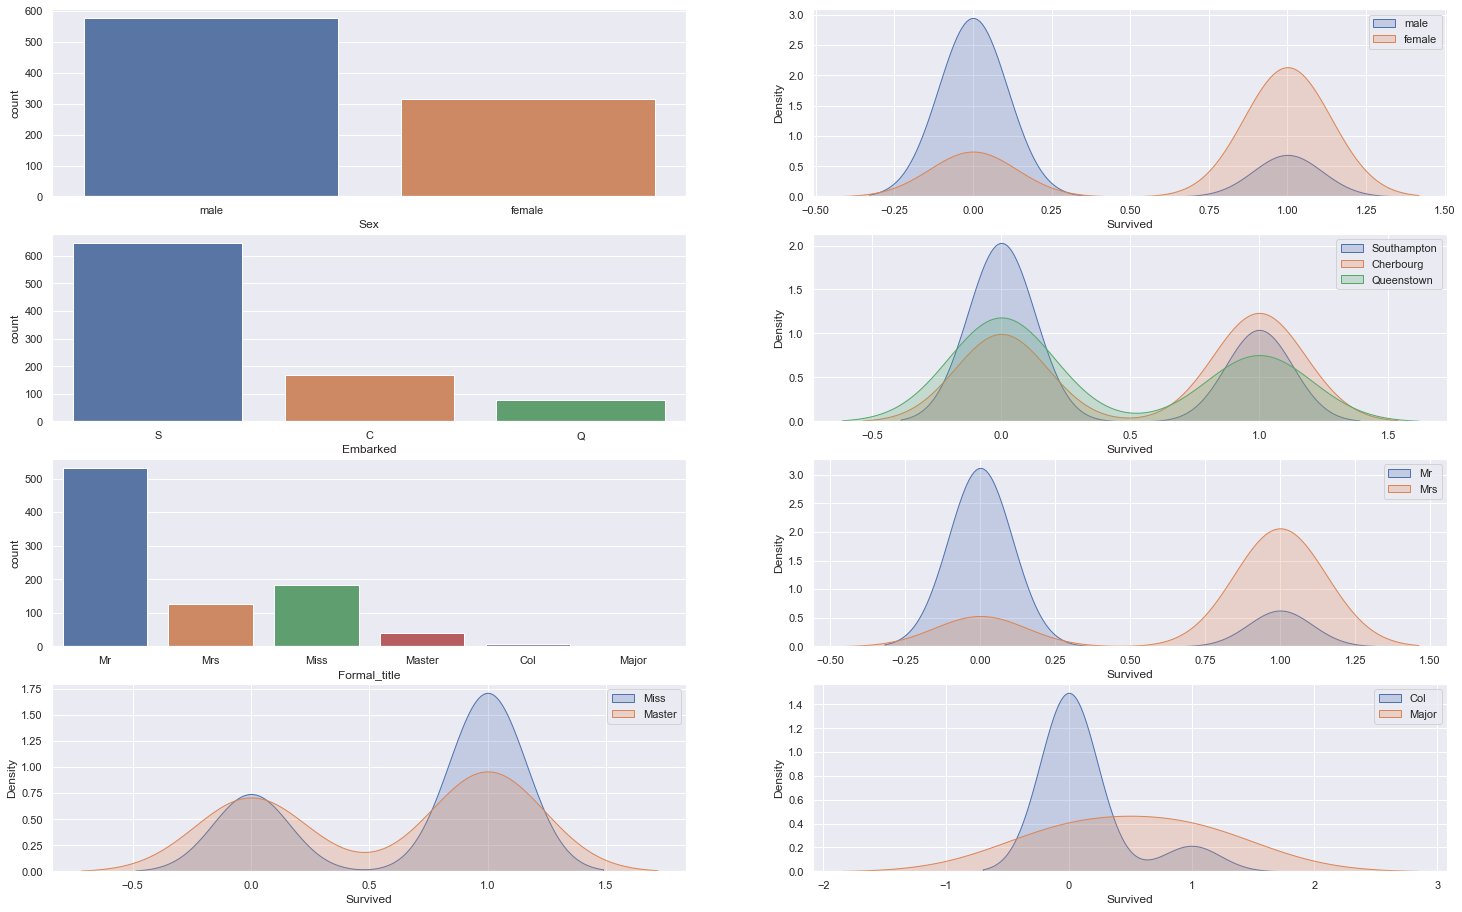

In [94]:
plt.figure( figsize=(25, 20))

# Sex
plt.subplot(5, 2, 1)
sns.countplot( x=df4['Sex'] )

plt.subplot(5, 2, 2)
sns.kdeplot(df4[df4['Sex'] == 'male']['Survived'], label  = 'male', shade = True)
sns.kdeplot(df4[df4['Sex'] == 'female']['Survived'], label = 'female', shade = True)
plt.legend()

# Embarked
plt.subplot(5, 2, 3)
sns.countplot( x=df4['Embarked'] )

plt.subplot(5, 2, 4)
sns.kdeplot(df4[df4['Embarked'] == 'S']['Survived'], label = 'Southampton', shade = True)
sns.kdeplot(df4[df4['Embarked'] == 'C']['Survived'], label  = 'Cherbourg', shade = True)
sns.kdeplot(df4[df4['Embarked'] == 'Q']['Survived'], label = 'Queenstown', shade = True)
plt.legend()

# Embarked
plt.subplot(5, 2, 5)
sns.countplot( x=df4['Formal_title'] )

plt.subplot(5, 2, 6)
sns.kdeplot(df4[df4['Formal_title'] == 'Mr']['Survived'], label  = 'Mr', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Mrs']['Survived'], label = 'Mrs', shade = True)
plt.legend()

plt.subplot(5, 2, 7)
sns.kdeplot(df4[df4['Formal_title'] == 'Miss']['Survived'], label = 'Miss', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Master']['Survived'], label = 'Master', shade = True)
plt.legend()

plt.subplot(5, 2, 8)
sns.kdeplot(df4[df4['Formal_title'] == 'Col']['Survived'], label = 'Col', shade = True)
sns.kdeplot(df4[df4['Formal_title'] == 'Major']['Survived'], label = 'Major', shade = True)
plt.legend()

plt.show()

From the graphs above, we can get some conclusions:

- **Sex**: Most women survived and most men died.
- **Embarked**: Most passengers who boarded the port of southampton didn't survive
- **Formal_title**: The formal title didn't influence the target variable